In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
##### LOAD #########
# choose load file name 
train_path="/home/bhagya/Cross_corpora_data_Bhagya/"
test_path="/home/bhagya/Cross_corpora_data_Bhagya/"

f1 = train_path+'X_Original_LDC_train_cms.npy'
f2 = train_path+'y_Original_LDC_train_cms.npy'
f3 = train_path+'X_train_LDC_kaldi_aug_mfcc_cms.npy'
f4 = train_path+'y_train_LDC_kaldi_aug_mfcc_cms.npy'
f5 = test_path+'X_Original_LDC_test_cms.npy'
f6 = test_path+'y_Original_LDC_test_cms.npy'

X_train = np.load(f1,allow_pickle=True)
X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5,allow_pickle=True)
y_train = np.load(f2,allow_pickle=True)
y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}') 
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(48261, 300, 20), y_train:(48261,)
X_aug:(53852, 300, 20), y_aug:(53852,)
X_valid:(7528, 300, 20), y_valid:(7528,)


In [3]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=object), array([ 9882,  2890, 16493, 10146,  8850]))
(array([0, 1, 2, 3, 4]), array([10515,  2217, 19841, 11097, 10182]))
(array([0, 1, 2, 3, 4], dtype=object), array([1580,  696, 2560, 1343, 1349]))


In [4]:
#not doing where separate source domains are needed as X_aug such as wgdrl
X_train=np.concatenate((X_train,X_aug))
del X_aug
y_train=np.concatenate((y_train,y_aug))
del y_aug

In [5]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(102113, 300, 20)
(array([0, 1, 2, 3, 4], dtype=object), array([20397,  5107, 36334, 21243, 19032]))


In [6]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector
    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [7]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [8]:
class_weights_train=imbalance_class_weight(y_train,5)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 20397
1 ---> 5107
2 ---> 36334
3 ---> 21243
4 ---> 19032
[1.00125509 3.99894263 0.56207959 0.96138022 1.07306641]
[0.25037996 1.         0.14055705 0.24040861 0.26833754]


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(20, 5).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
def xv_data_manage(X_test):
     aa=X_test.transpose((0,2,1))
     print(X_test.shape, '-->', aa.shape)
     return aa

In [11]:
 X_train=xv_data_manage(X_train)
 X_valid=xv_data_manage(X_valid)

(102113, 300, 20) --> (102113, 20, 300)
(7528, 300, 20) --> (7528, 20, 300)


In [12]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

341
236


Epoch: 0, Batch: 0, Loss: 8.53091812133789, Accuracy:20.333333333333332%
Epoch: 0, Batch: 50, Loss: 5.403229713439941, Accuracy:61.0%
Epoch: 0, Batch: 100, Loss: 5.209021091461182, Accuracy:64.0%
Epoch: 0, Batch: 150, Loss: 4.944814682006836, Accuracy:62.33333333333333%
Epoch: 0, Batch: 200, Loss: 3.980919122695923, Accuracy:73.33333333333333%
Epoch: 0, Batch: 250, Loss: 4.163112163543701, Accuracy:70.33333333333334%
Epoch: 0, Batch: 300, Loss: 4.0716023445129395, Accuracy:71.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 6.142533779144287, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 5.533379077911377, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 10.633437156677246, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 0, Batch: 150, Loss: 1.8567650318145752, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 0, Batch: 200, Loss: 0.9581508040428162, Accuracy:75.0%


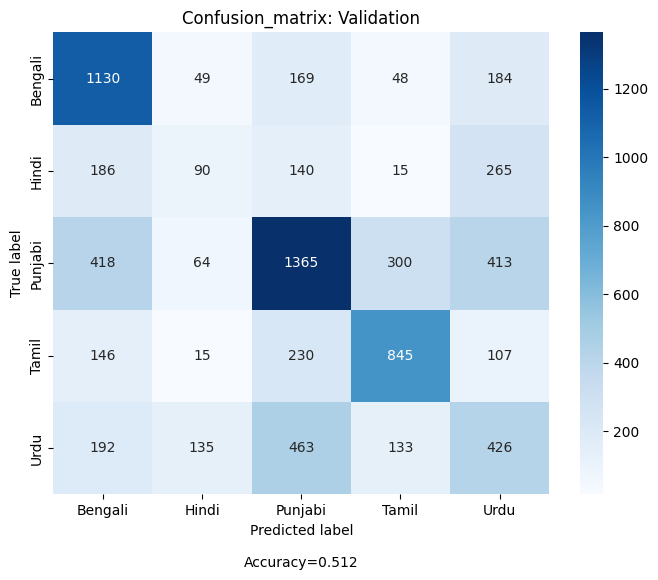

:::::Total vlidation loss 3.404754763321498, Training accuracy 0.6454124352433089, Validation accuracy 0.512221041445271 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 3.708918809890747, Accuracy:74.66666666666667%
Epoch: 1, Batch: 50, Loss: 3.1143712997436523, Accuracy:81.0%
Epoch: 1, Batch: 100, Loss: 3.107680320739746, Accuracy:79.66666666666666%
Epoch: 1, Batch: 150, Loss: 3.014360189437866, Accuracy:78.66666666666666%
Epoch: 1, Batch: 200, Loss: 3.070868492126465, Accuracy:79.66666666666666%
Epoch: 1, Batch: 250, Loss: 2.793105125427246, Accuracy:80.33333333333333%
Epoch: 1, Batch: 300, Loss: 2.796527147293091, Accuracy:79.33333333333333%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 5.772752285003662, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 5.120081901550293, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 14.035917282104492, Accuracy:3.125%
#####TEST--in-domain:::::Epoc

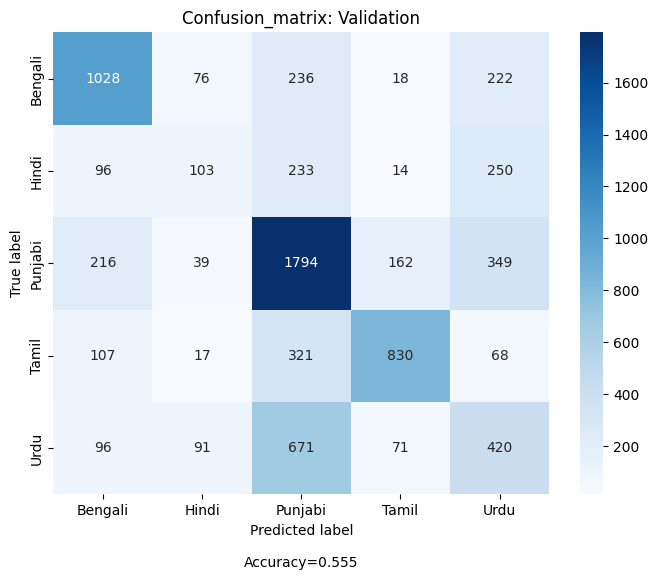

:::::Total vlidation loss 3.4516530179312097, Training accuracy 0.7951387188702712, Validation accuracy 0.554596174282678 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 2.048393487930298, Accuracy:87.0%
Epoch: 2, Batch: 50, Loss: 2.247722864151001, Accuracy:85.0%
Epoch: 2, Batch: 100, Loss: 2.567086696624756, Accuracy:80.66666666666666%
Epoch: 2, Batch: 150, Loss: 2.462731122970581, Accuracy:82.0%
Epoch: 2, Batch: 200, Loss: 2.0420727729797363, Accuracy:86.66666666666667%
Epoch: 2, Batch: 250, Loss: 2.112915515899658, Accuracy:86.66666666666667%
Epoch: 2, Batch: 300, Loss: 2.1108007431030273, Accuracy:87.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 5.084524631500244, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 3.9077975749969482, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 13.157944679260254, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 2, Batch: 150, Loss: 2.059667825

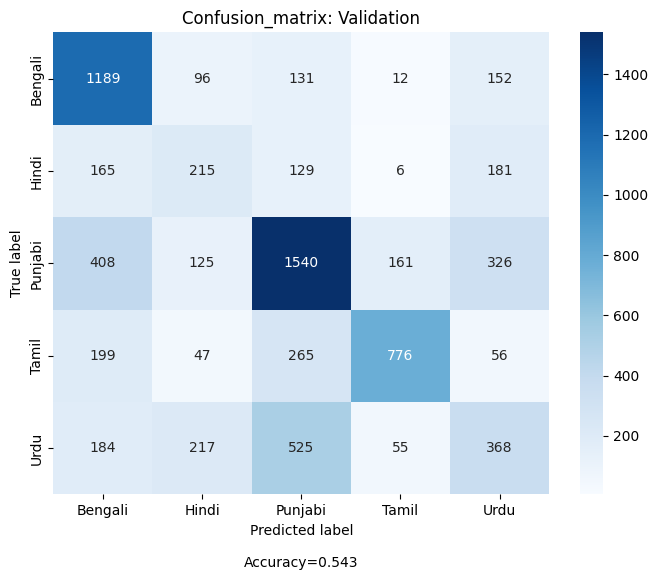

:::::Total vlidation loss 3.9318767889369033, Training accuracy 0.8506458531235004, Validation accuracy 0.5430393198724761 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 2.2682011127471924, Accuracy:85.66666666666667%
Epoch: 3, Batch: 50, Loss: 1.7654520273208618, Accuracy:89.0%
Epoch: 3, Batch: 100, Loss: 1.8028181791305542, Accuracy:88.33333333333333%
Epoch: 3, Batch: 150, Loss: 1.7823095321655273, Accuracy:89.33333333333333%
Epoch: 3, Batch: 200, Loss: 1.3949470520019531, Accuracy:91.33333333333333%
Epoch: 3, Batch: 250, Loss: 1.9374942779541016, Accuracy:88.66666666666667%
Epoch: 3, Batch: 300, Loss: 1.772939682006836, Accuracy:89.66666666666666%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 8.922744750976562, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 5.687328338623047, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 14.362695693969727, Accuracy:15.625%
#####TEST--in-domain

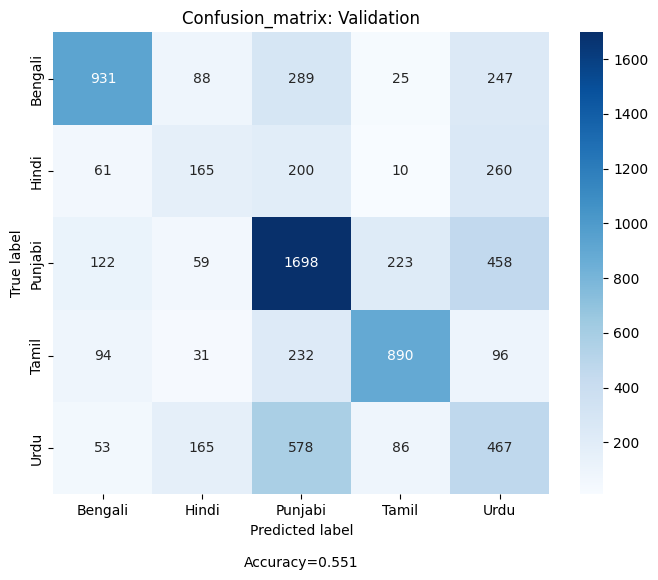

:::::Total vlidation loss 3.9426212819616175, Training accuracy 0.8863611880955412, Validation accuracy 0.5514080765143464 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 1.3922150135040283, Accuracy:91.0%
Epoch: 4, Batch: 50, Loss: 1.374482274055481, Accuracy:92.0%
Epoch: 4, Batch: 100, Loss: 1.2643355131149292, Accuracy:91.66666666666666%
Epoch: 4, Batch: 150, Loss: 1.5131877660751343, Accuracy:90.66666666666666%
Epoch: 4, Batch: 200, Loss: 1.224514365196228, Accuracy:94.0%
Epoch: 4, Batch: 250, Loss: 1.5252639055252075, Accuracy:90.66666666666666%
Epoch: 4, Batch: 300, Loss: 1.2027965784072876, Accuracy:94.66666666666667%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 5.197999000549316, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 6.36677885055542, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 14.929293632507324, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 4, Batch: 150, Los

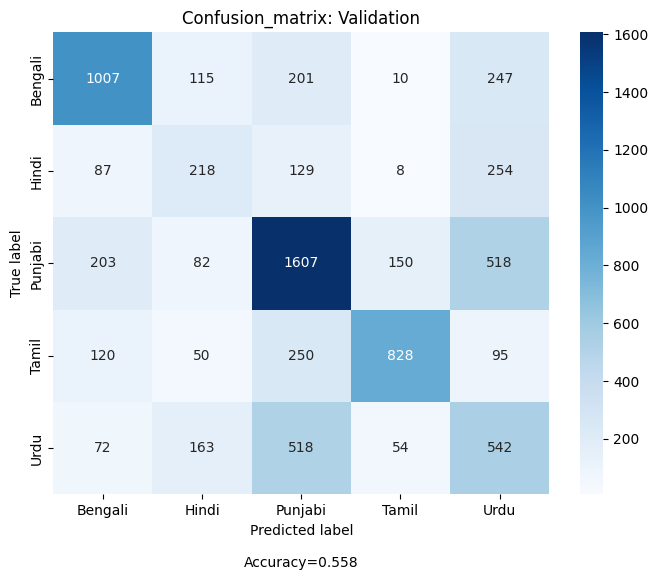

:::::Total vlidation loss 4.163397406098873, Training accuracy 0.9112747642317824, Validation accuracy 0.558182784272051 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 1.117743730545044, Accuracy:94.0%
Epoch: 5, Batch: 50, Loss: 1.1525622606277466, Accuracy:93.66666666666667%
Epoch: 5, Batch: 100, Loss: 0.9828767776489258, Accuracy:93.0%
Epoch: 5, Batch: 150, Loss: 1.1188838481903076, Accuracy:93.66666666666667%
Epoch: 5, Batch: 200, Loss: 1.158930778503418, Accuracy:93.33333333333333%
Epoch: 5, Batch: 250, Loss: 0.9309430122375488, Accuracy:94.66666666666667%
Epoch: 5, Batch: 300, Loss: 1.2715845108032227, Accuracy:91.66666666666666%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 5.410229206085205, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 6.5209641456604, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 14.052207946777344, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 5, Bat

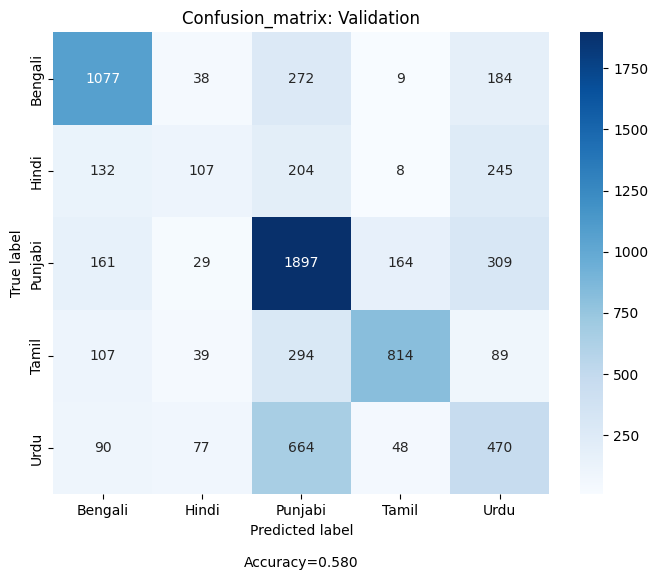

:::::Total vlidation loss 4.36731552782237, Training accuracy 0.9320164915338889, Validation accuracy 0.5798352816153028 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 0.8943226933479309, Accuracy:94.33333333333334%
Epoch: 6, Batch: 50, Loss: 0.854688286781311, Accuracy:95.0%
Epoch: 6, Batch: 100, Loss: 0.8748628497123718, Accuracy:95.33333333333334%
Epoch: 6, Batch: 150, Loss: 0.8690739870071411, Accuracy:95.33333333333334%
Epoch: 6, Batch: 200, Loss: 1.1312934160232544, Accuracy:94.33333333333334%
Epoch: 6, Batch: 250, Loss: 0.8327801823616028, Accuracy:95.66666666666667%
Epoch: 6, Batch: 300, Loss: 0.9163704514503479, Accuracy:95.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 8.273970603942871, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 6.594816207885742, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 12.606646537780762, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 6, Batch

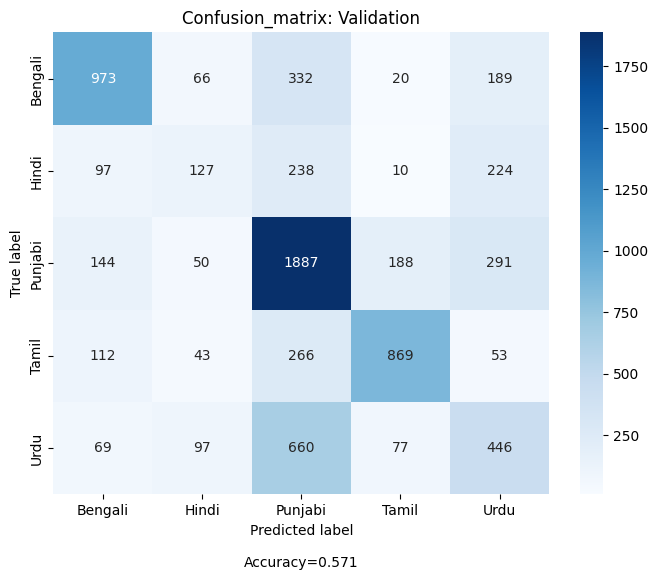

:::::Total vlidation loss 4.485468048446542, Training accuracy 0.9479008549352188, Validation accuracy 0.5714665249734325 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 0.829788327217102, Accuracy:94.66666666666667%
Epoch: 7, Batch: 50, Loss: 0.5698016881942749, Accuracy:96.66666666666667%
Epoch: 7, Batch: 100, Loss: 0.8456089496612549, Accuracy:95.66666666666667%
Epoch: 7, Batch: 150, Loss: 0.6582527160644531, Accuracy:96.66666666666667%
Epoch: 7, Batch: 200, Loss: 0.7340112924575806, Accuracy:95.66666666666667%
Epoch: 7, Batch: 250, Loss: 0.7067916989326477, Accuracy:95.66666666666667%
Epoch: 7, Batch: 300, Loss: 0.819281816482544, Accuracy:95.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 7.912551403045654, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 12.232808113098145, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 15.059184074401855, Accuracy:6.25%
#####TEST--in-domain:::::

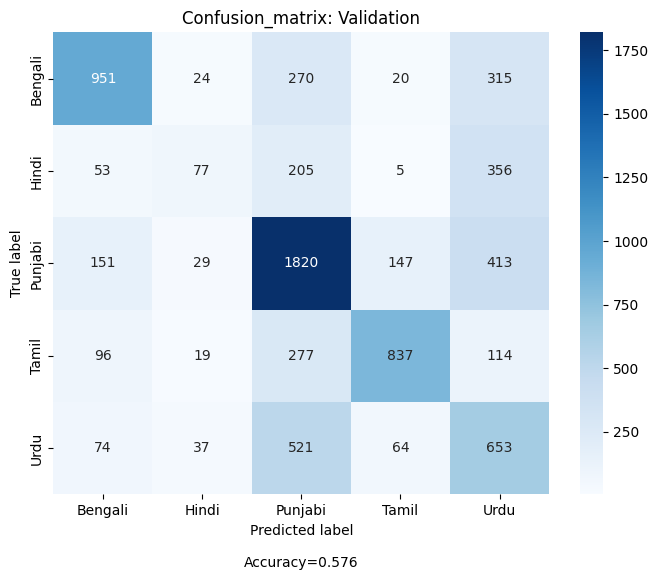

:::::Total vlidation loss 4.815279035179347, Training accuracy 0.9606024698128544, Validation accuracy 0.5762486716259299 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 0.47840407490730286, Accuracy:97.33333333333334%
Epoch: 8, Batch: 50, Loss: 0.400963693857193, Accuracy:98.66666666666667%
Epoch: 8, Batch: 100, Loss: 0.4121599495410919, Accuracy:97.66666666666667%
Epoch: 8, Batch: 150, Loss: 0.5260316133499146, Accuracy:96.66666666666667%
Epoch: 8, Batch: 200, Loss: 0.48557621240615845, Accuracy:97.66666666666667%
Epoch: 8, Batch: 250, Loss: 0.4321781396865845, Accuracy:97.33333333333334%
Epoch: 8, Batch: 300, Loss: 0.5702002644538879, Accuracy:96.66666666666667%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 4.207669734954834, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 6.47005558013916, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 14.449474334716797, Accuracy:15.625%
#####TES

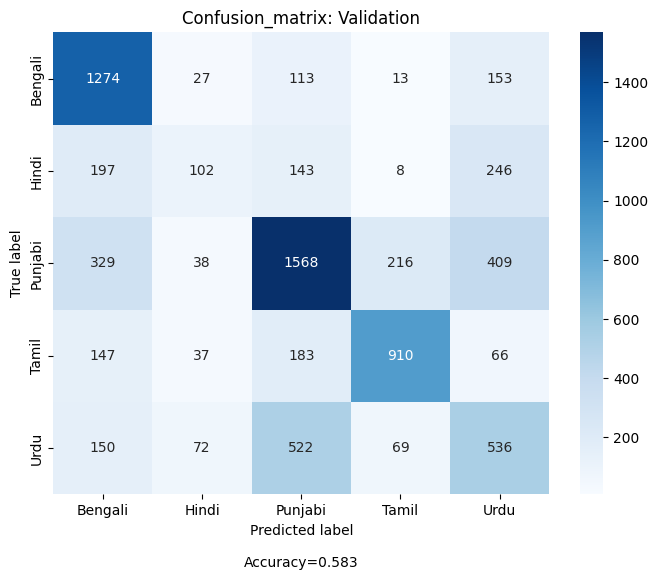

:::::Total vlidation loss 4.8082203521016025, Training accuracy 0.9719036753400644, Validation accuracy 0.5831562167906482 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 0.31577759981155396, Accuracy:99.0%
Epoch: 9, Batch: 50, Loss: 0.42749008536338806, Accuracy:97.33333333333334%
Epoch: 9, Batch: 100, Loss: 0.4815171957015991, Accuracy:97.33333333333334%
Epoch: 9, Batch: 150, Loss: 0.2681095004081726, Accuracy:99.66666666666667%
Epoch: 9, Batch: 200, Loss: 0.44041767716407776, Accuracy:98.0%
Epoch: 9, Batch: 250, Loss: 0.2930898666381836, Accuracy:98.66666666666667%
Epoch: 9, Batch: 300, Loss: 0.46169984340667725, Accuracy:98.33333333333333%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 6.172699451446533, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 4.474543571472168, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 13.705930709838867, Accuracy:21.875%
#####TEST--in-domain:::::Epoch:

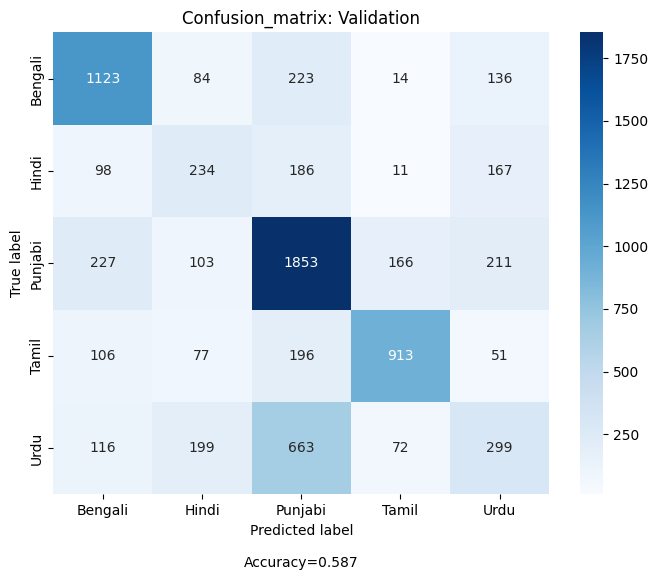

:::::Total vlidation loss 4.953114470123589, Training accuracy 0.9779655871436546, Validation accuracy 0.5874070138150903 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 0.3053033947944641, Accuracy:98.0%
Epoch: 10, Batch: 50, Loss: 0.41241756081581116, Accuracy:97.66666666666667%
Epoch: 10, Batch: 100, Loss: 0.45139753818511963, Accuracy:97.66666666666667%
Epoch: 10, Batch: 150, Loss: 0.3964577913284302, Accuracy:98.33333333333333%
Epoch: 10, Batch: 200, Loss: 0.3152678310871124, Accuracy:98.33333333333333%
Epoch: 10, Batch: 250, Loss: 0.3191661834716797, Accuracy:98.66666666666667%
Epoch: 10, Batch: 300, Loss: 0.37303879857063293, Accuracy:97.66666666666667%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 4.611464500427246, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 7.768563270568848, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 15.593289375305176, Accuracy:15.625%
#####T

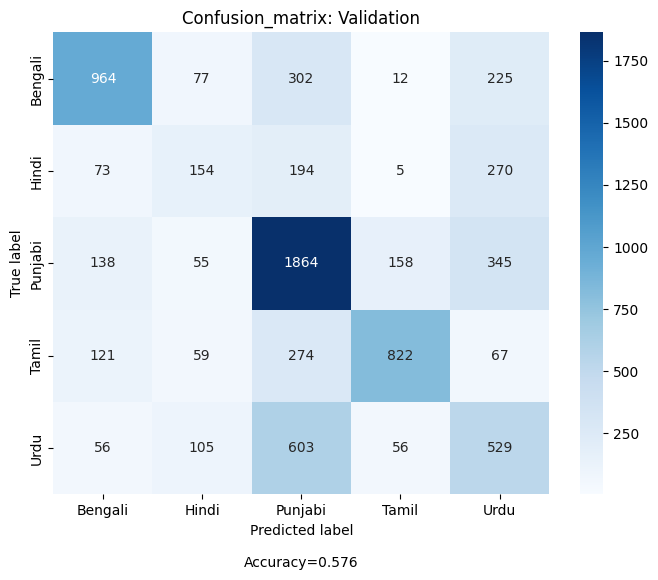

:::::Total vlidation loss 5.1374036003378345, Training accuracy 0.9841548088881925, Validation accuracy 0.5755844845908608 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 0.296482115983963, Accuracy:98.0%
Epoch: 11, Batch: 50, Loss: 0.2689113914966583, Accuracy:98.33333333333333%
Epoch: 11, Batch: 100, Loss: 0.15701454877853394, Accuracy:99.33333333333333%
Epoch: 11, Batch: 150, Loss: 0.3288190960884094, Accuracy:98.66666666666667%
Epoch: 11, Batch: 200, Loss: 0.271810919046402, Accuracy:99.0%
Epoch: 11, Batch: 250, Loss: 0.18257135152816772, Accuracy:99.33333333333333%
Epoch: 11, Batch: 300, Loss: 0.3895482122898102, Accuracy:97.66666666666667%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 5.898127555847168, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 11.213937759399414, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 15.558561325073242, Accuracy:18.75%
#####TEST--in-domain::::

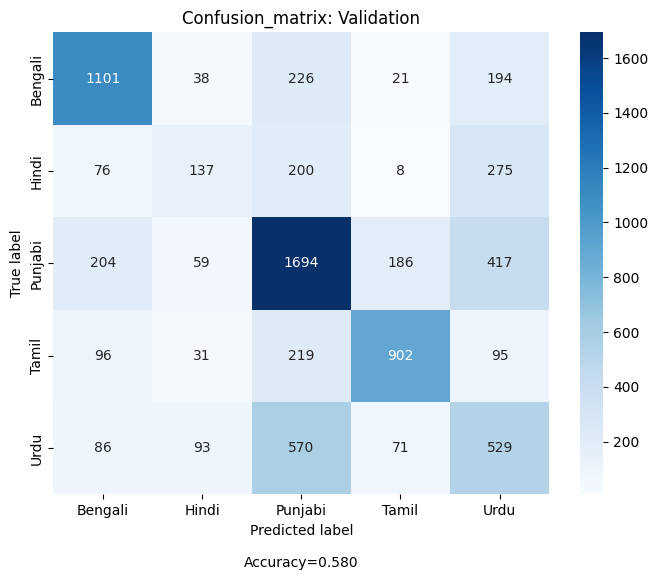

:::::Total vlidation loss 5.546582399119768, Training accuracy 0.9864365947528718, Validation accuracy 0.5795696068012752 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 0.2736372649669647, Accuracy:99.0%
Epoch: 12, Batch: 50, Loss: 0.1725795418024063, Accuracy:99.33333333333333%
Epoch: 12, Batch: 100, Loss: 0.16397711634635925, Accuracy:99.66666666666667%
Epoch: 12, Batch: 150, Loss: 0.17109714448451996, Accuracy:99.66666666666667%
Epoch: 12, Batch: 200, Loss: 0.22103165090084076, Accuracy:98.66666666666667%
Epoch: 12, Batch: 250, Loss: 0.28050631284713745, Accuracy:98.33333333333333%
Epoch: 12, Batch: 300, Loss: 0.28198572993278503, Accuracy:98.33333333333333%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 4.026072978973389, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 8.081936836242676, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 18.70284080505371, Accuracy:3.125%
#####TE

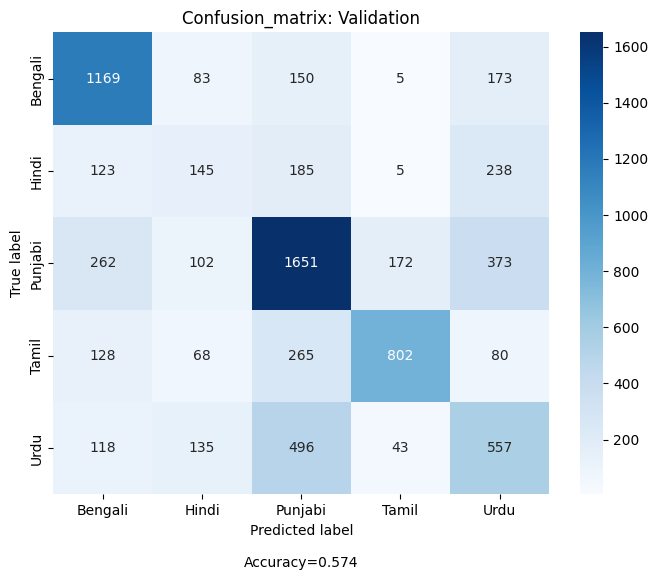

:::::Total vlidation loss 5.563616881527705, Training accuracy 0.9903832029222528, Validation accuracy 0.5743889479277364 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 0.10531099885702133, Accuracy:99.33333333333333%
Epoch: 13, Batch: 50, Loss: 0.3070635497570038, Accuracy:98.33333333333333%
Epoch: 13, Batch: 100, Loss: 0.15221631526947021, Accuracy:99.66666666666667%
Epoch: 13, Batch: 150, Loss: 0.332602858543396, Accuracy:98.0%
Epoch: 13, Batch: 200, Loss: 0.13948556780815125, Accuracy:99.66666666666667%
Epoch: 13, Batch: 250, Loss: 0.1789814680814743, Accuracy:99.0%
Epoch: 13, Batch: 300, Loss: 0.22033914923667908, Accuracy:99.33333333333333%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 4.279412746429443, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 9.699271202087402, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 17.503067016601562, Accuracy:12.5%
#####TEST--in-domain:

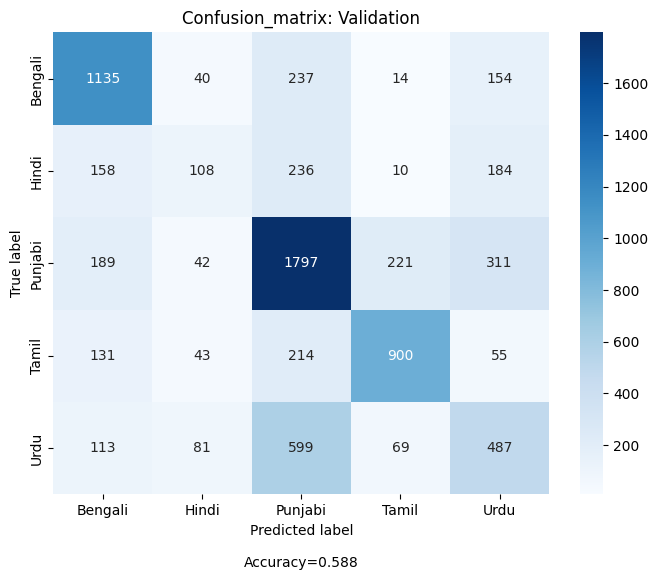

:::::Total vlidation loss 5.502449709305778, Training accuracy 0.9909707872650887, Validation accuracy 0.5880712008501594 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 0.21717499196529388, Accuracy:99.0%
Epoch: 14, Batch: 50, Loss: 0.1363573521375656, Accuracy:99.33333333333333%
Epoch: 14, Batch: 100, Loss: 0.15445594489574432, Accuracy:99.33333333333333%
Epoch: 14, Batch: 150, Loss: 0.09672245383262634, Accuracy:99.66666666666667%
Epoch: 14, Batch: 200, Loss: 0.07573121041059494, Accuracy:100.0%
Epoch: 14, Batch: 250, Loss: 0.21243523061275482, Accuracy:98.66666666666667%
Epoch: 14, Batch: 300, Loss: 0.08546657860279083, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 7.6226043701171875, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 12.037481307983398, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 19.032724380493164, Accuracy:12.5%
#####TEST--in-domain:::::Epoch

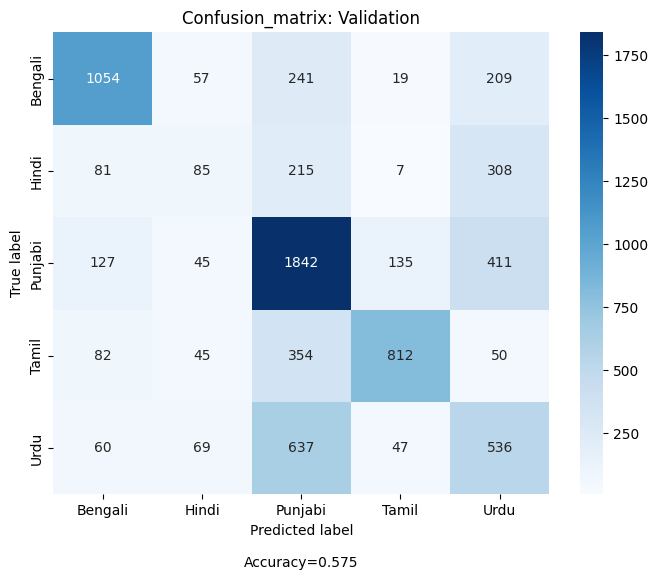

:::::Total vlidation loss 5.905955181480787, Training accuracy 0.9935071930116636, Validation accuracy 0.5750531349628055 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 0.16485731303691864, Accuracy:99.0%
Epoch: 15, Batch: 50, Loss: 0.16049927473068237, Accuracy:99.0%
Epoch: 15, Batch: 100, Loss: 0.12037838250398636, Accuracy:100.0%
Epoch: 15, Batch: 150, Loss: 0.12500716745853424, Accuracy:99.33333333333333%
Epoch: 15, Batch: 200, Loss: 0.14412860572338104, Accuracy:99.0%
Epoch: 15, Batch: 250, Loss: 0.04196283966302872, Accuracy:100.0%
Epoch: 15, Batch: 300, Loss: 0.18019439280033112, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 6.063191890716553, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 11.010750770568848, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 19.63689422607422, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 15, Batch: 150, Loss: 2.344776630

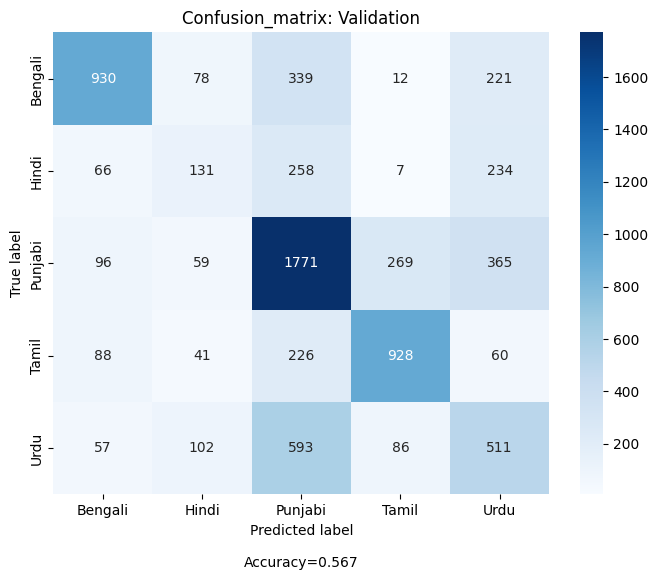

:::::Total vlidation loss 6.06727060166219, Training accuracy 0.993693261386895, Validation accuracy 0.5673485653560042 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 0.08836374431848526, Accuracy:99.66666666666667%
Epoch: 16, Batch: 50, Loss: 0.13542422652244568, Accuracy:99.33333333333333%
Epoch: 16, Batch: 100, Loss: 0.0852404311299324, Accuracy:100.0%
Epoch: 16, Batch: 150, Loss: 0.10035042464733124, Accuracy:99.66666666666667%
Epoch: 16, Batch: 200, Loss: 0.07741574943065643, Accuracy:99.66666666666667%
Epoch: 16, Batch: 250, Loss: 0.13482831418514252, Accuracy:99.33333333333333%
Epoch: 16, Batch: 300, Loss: 0.15482325851917267, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 8.104867935180664, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 8.614533424377441, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 13.523950576782227, Accuracy:25.0%
#####TEST--in-domain

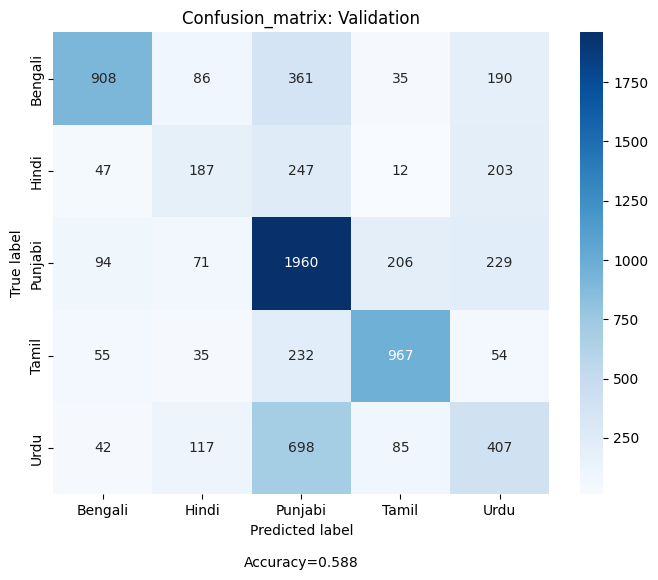

:::::Total vlidation loss 5.871479922814966, Training accuracy 0.9937911921107009, Validation accuracy 0.588336875664187 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 0.1408979892730713, Accuracy:99.66666666666667%
Epoch: 17, Batch: 50, Loss: 0.12329795956611633, Accuracy:99.0%
Epoch: 17, Batch: 100, Loss: 0.1289651244878769, Accuracy:99.0%
Epoch: 17, Batch: 150, Loss: 0.13623212277889252, Accuracy:99.33333333333333%
Epoch: 17, Batch: 200, Loss: 0.043137017637491226, Accuracy:100.0%
Epoch: 17, Batch: 250, Loss: 0.0499303825199604, Accuracy:100.0%
Epoch: 17, Batch: 300, Loss: 0.09677727520465851, Accuracy:99.66666666666667%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 5.756719589233398, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 11.832998275756836, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 21.61565589904785, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 17, Batch: 150

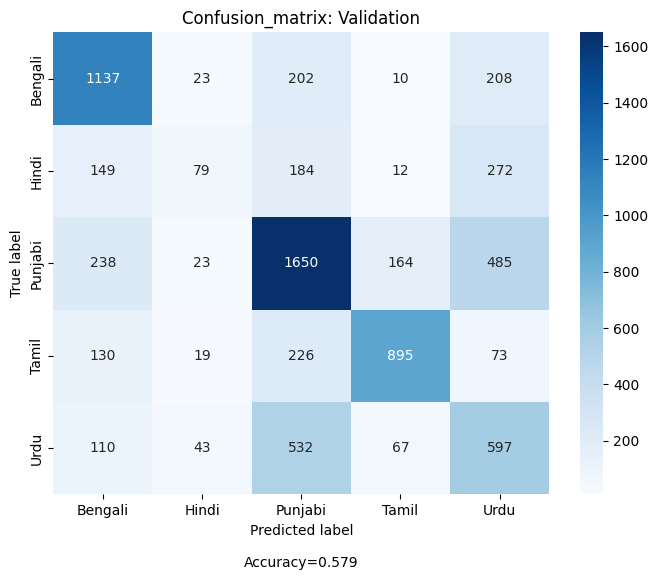

:::::Total vlidation loss 6.126636793886917, Training accuracy 0.9952405668230294, Validation accuracy 0.5789054197662061 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 0.07355020940303802, Accuracy:100.0%
Epoch: 18, Batch: 50, Loss: 0.1386839747428894, Accuracy:99.0%
Epoch: 18, Batch: 100, Loss: 0.05536522716283798, Accuracy:100.0%
Epoch: 18, Batch: 150, Loss: 0.10780971497297287, Accuracy:99.33333333333333%
Epoch: 18, Batch: 200, Loss: 0.1243627518415451, Accuracy:99.33333333333333%
Epoch: 18, Batch: 250, Loss: 0.11902094632387161, Accuracy:99.66666666666667%
Epoch: 18, Batch: 300, Loss: 0.18437203764915466, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 6.19123649597168, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 6.67748498916626, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 14.011577606201172, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 18, Batch: 1

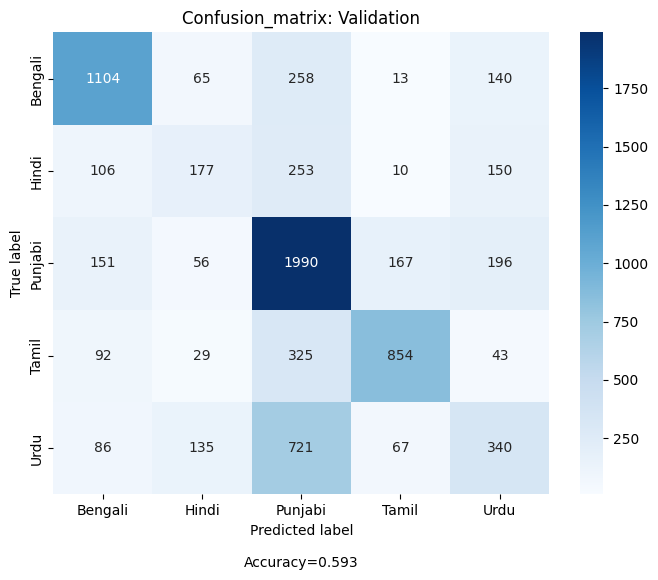

:::::Total vlidation loss 5.955918791436775, Training accuracy 0.9955343589944473, Validation accuracy 0.5931190223166843 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 0.07220550626516342, Accuracy:99.66666666666667%
Epoch: 19, Batch: 50, Loss: 0.03905671462416649, Accuracy:100.0%
Epoch: 19, Batch: 100, Loss: 0.02423482947051525, Accuracy:100.0%
Epoch: 19, Batch: 150, Loss: 0.036563146859407425, Accuracy:100.0%
Epoch: 19, Batch: 200, Loss: 0.011522975750267506, Accuracy:100.0%
Epoch: 19, Batch: 250, Loss: 0.015009569935500622, Accuracy:100.0%
Epoch: 19, Batch: 300, Loss: 0.01328122615814209, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 5.11967134475708, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 8.802506446838379, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 15.281533241271973, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 19, Batch: 150, Loss: 1.926567

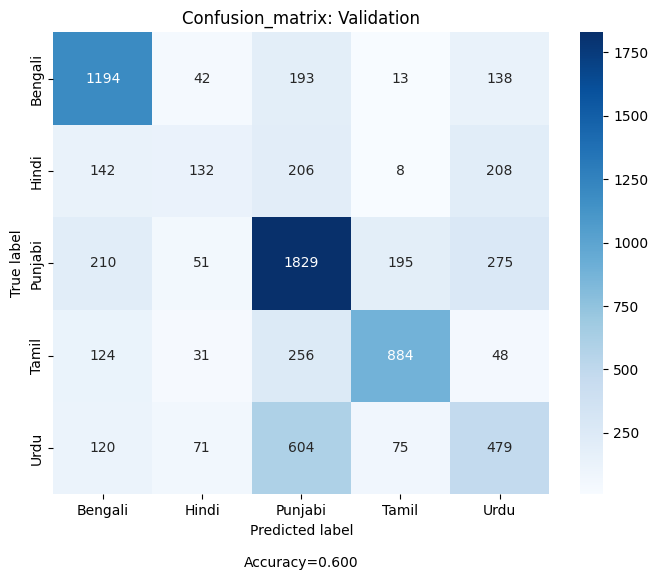

:::::Total vlidation loss 5.813542547473781, Training accuracy 0.9990696581238432, Validation accuracy 0.6001594048884166 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 0.017489135265350342, Accuracy:100.0%
Epoch: 20, Batch: 50, Loss: 0.012209923006594181, Accuracy:100.0%
Epoch: 20, Batch: 100, Loss: 0.01636406034231186, Accuracy:100.0%
Epoch: 20, Batch: 150, Loss: 0.008686061948537827, Accuracy:100.0%
Epoch: 20, Batch: 200, Loss: 0.05204513669013977, Accuracy:99.66666666666667%
Epoch: 20, Batch: 250, Loss: 0.01156405359506607, Accuracy:100.0%
Epoch: 20, Batch: 300, Loss: 0.024669099599123, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 6.467588901519775, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 7.1852569580078125, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 15.647974967956543, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 20, Batch: 150, Loss: 1.4794

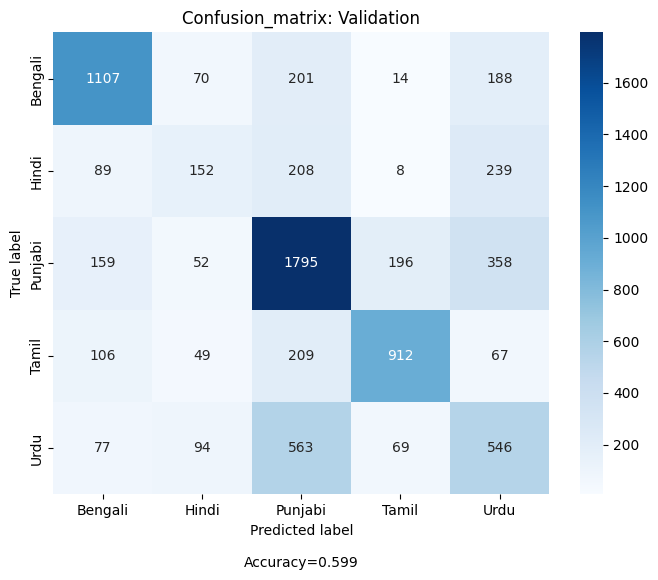

:::::Total vlidation loss 5.658327815627059, Training accuracy 0.9996376563219179, Validation accuracy 0.5993623804463337 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 0.013349809683859348, Accuracy:100.0%
Epoch: 21, Batch: 50, Loss: 0.009646225720643997, Accuracy:100.0%
Epoch: 21, Batch: 100, Loss: 0.05629458278417587, Accuracy:99.66666666666667%
Epoch: 21, Batch: 150, Loss: 0.023489423096179962, Accuracy:100.0%
Epoch: 21, Batch: 200, Loss: 0.0018169748364016414, Accuracy:100.0%
Epoch: 21, Batch: 250, Loss: 0.02424701303243637, Accuracy:100.0%
Epoch: 21, Batch: 300, Loss: 0.013257836923003197, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 5.224033355712891, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 21, Batch: 50, Loss: 8.161636352539062, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 21, Batch: 100, Loss: 15.381339073181152, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 150, Loss: 2.9

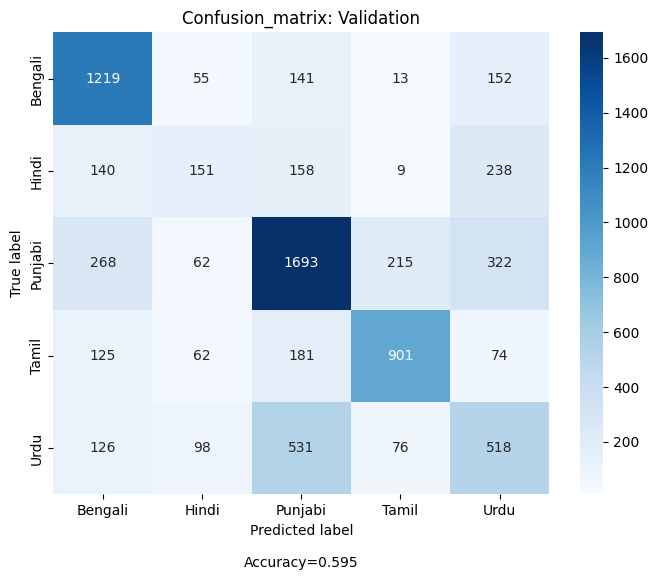

:::::Total vlidation loss 5.79744208171747, Training accuracy 0.9995788978876343, Validation accuracy 0.5953772582359192 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 22, Batch: 0, Loss: 0.020656157284975052, Accuracy:100.0%
Epoch: 22, Batch: 50, Loss: 0.003260767087340355, Accuracy:100.0%
Epoch: 22, Batch: 100, Loss: 0.06453961879014969, Accuracy:99.66666666666667%
Epoch: 22, Batch: 150, Loss: 0.02282445877790451, Accuracy:100.0%
Epoch: 22, Batch: 200, Loss: 0.026099037379026413, Accuracy:100.0%
Epoch: 22, Batch: 250, Loss: 0.017853548750281334, Accuracy:100.0%
Epoch: 22, Batch: 300, Loss: 0.010251152329146862, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 6.590307712554932, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 22, Batch: 50, Loss: 8.909217834472656, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 22, Batch: 100, Loss: 20.429601669311523, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 22, Batch: 150, Loss: 1.721

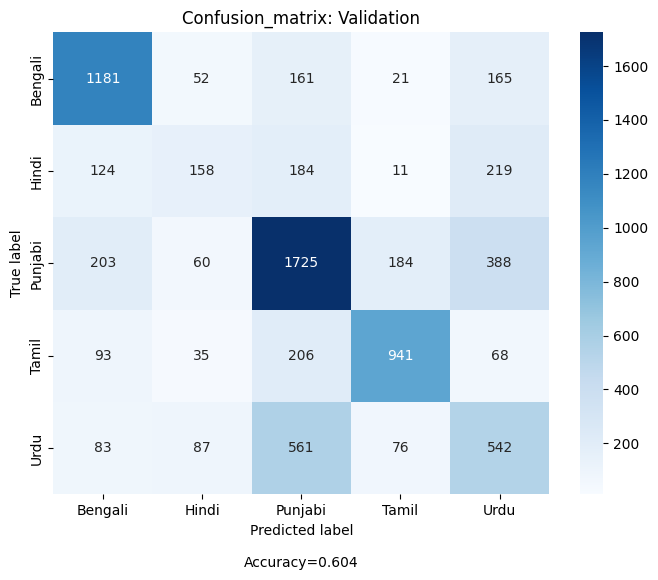

:::::Total vlidation loss 5.831199457252477, Training accuracy 0.9995201394533507, Validation accuracy 0.6040116896918172 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 0.0011490044416859746, Accuracy:100.0%
Epoch: 23, Batch: 50, Loss: 0.007633235305547714, Accuracy:100.0%
Epoch: 23, Batch: 100, Loss: 0.006756201386451721, Accuracy:100.0%
Epoch: 23, Batch: 150, Loss: 0.0056716869585216045, Accuracy:100.0%
Epoch: 23, Batch: 200, Loss: 0.0034322114661335945, Accuracy:100.0%
Epoch: 23, Batch: 250, Loss: 0.0012446881737560034, Accuracy:100.0%
Epoch: 23, Batch: 300, Loss: 0.0005834564799442887, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 6.0994343757629395, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 23, Batch: 50, Loss: 8.972816467285156, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 100, Loss: 16.65071678161621, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 23, Batch: 150, Loss: 2.343798

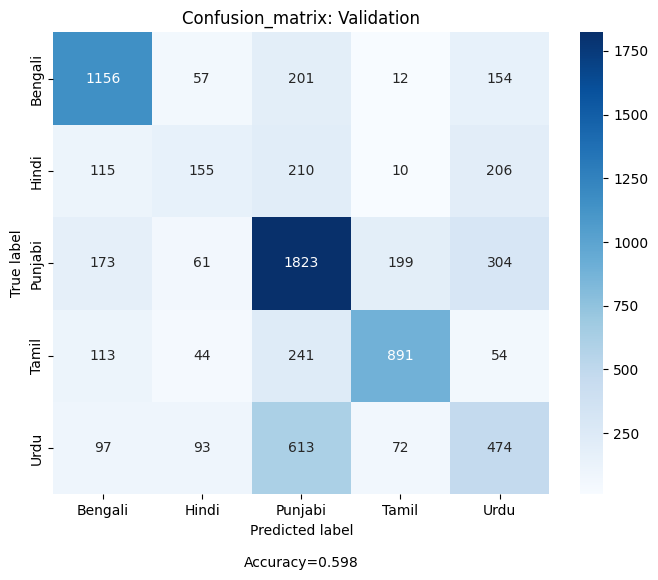

:::::Total vlidation loss 5.916328937548093, Training accuracy 0.9998726900590522, Validation accuracy 0.597635494155154 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 0.0028236769139766693, Accuracy:100.0%
Epoch: 24, Batch: 50, Loss: 0.0025948979891836643, Accuracy:100.0%
Epoch: 24, Batch: 100, Loss: 0.009207728318870068, Accuracy:100.0%
Epoch: 24, Batch: 150, Loss: 0.00156951614189893, Accuracy:100.0%
Epoch: 24, Batch: 200, Loss: 0.03190302103757858, Accuracy:99.66666666666667%
Epoch: 24, Batch: 250, Loss: 0.0013716471148654819, Accuracy:100.0%
Epoch: 24, Batch: 300, Loss: 0.014762387610971928, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 5.211120128631592, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 24, Batch: 50, Loss: 9.042969703674316, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 24, Batch: 100, Loss: 17.925800323486328, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 150, Loss: 2.59

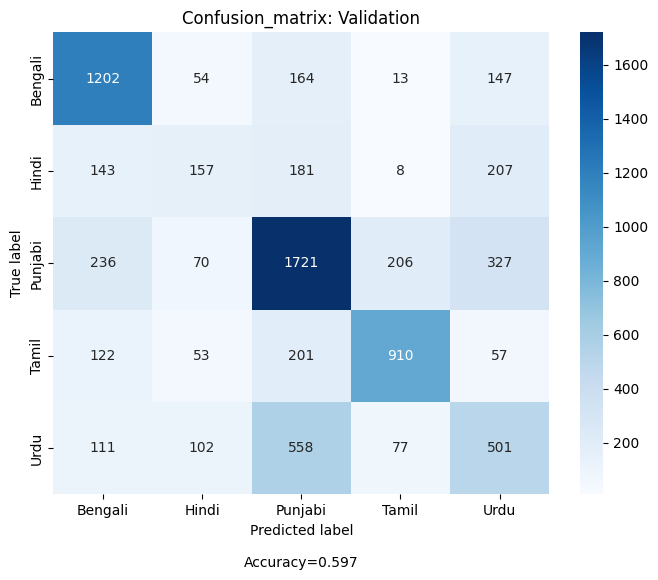

:::::Total vlidation loss 5.833064260471624, Training accuracy 0.999951034638097, Validation accuracy 0.5965727948990436 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 0.030550295487046242, Accuracy:99.66666666666667%
Epoch: 25, Batch: 50, Loss: 0.0018283736426383257, Accuracy:100.0%
Epoch: 25, Batch: 100, Loss: 0.0006533666746690869, Accuracy:100.0%
Epoch: 25, Batch: 150, Loss: 0.00073386135045439, Accuracy:100.0%
Epoch: 25, Batch: 200, Loss: 0.001896675443276763, Accuracy:100.0%
Epoch: 25, Batch: 250, Loss: 0.0009064805344678462, Accuracy:100.0%
Epoch: 25, Batch: 300, Loss: 0.004505220800638199, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 5.5850982666015625, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 25, Batch: 50, Loss: 7.934833526611328, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 25, Batch: 100, Loss: 18.019529342651367, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 25, Batch: 150, Loss: 3

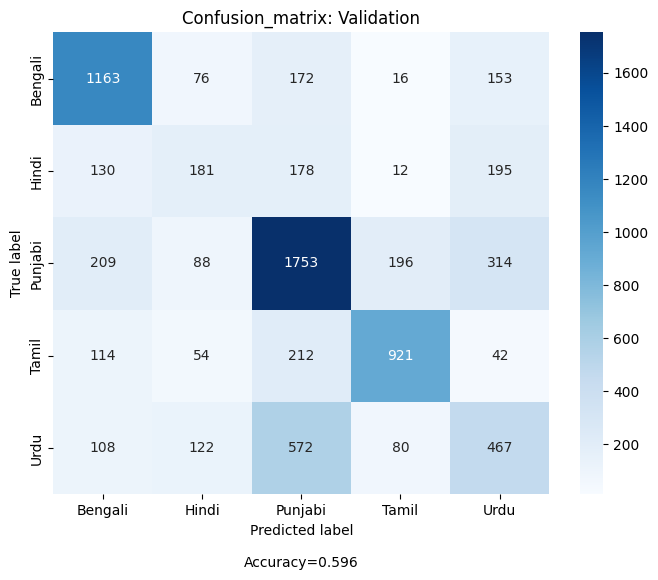

:::::Total vlidation loss 5.789115137344176, Training accuracy 0.9999706207828583, Validation accuracy 0.5957757704569607 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 26, Batch: 0, Loss: 0.0031543069053441286, Accuracy:100.0%
Epoch: 26, Batch: 50, Loss: 0.014225930906832218, Accuracy:100.0%
Epoch: 26, Batch: 100, Loss: 0.0005210391245782375, Accuracy:100.0%
Epoch: 26, Batch: 150, Loss: 0.0012588007375597954, Accuracy:100.0%
Epoch: 26, Batch: 200, Loss: 0.0007857406162656844, Accuracy:100.0%
Epoch: 26, Batch: 250, Loss: 0.0010088395792990923, Accuracy:100.0%
Epoch: 26, Batch: 300, Loss: 0.006429123226553202, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 7.251355171203613, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 26, Batch: 50, Loss: 10.106490135192871, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 26, Batch: 100, Loss: 18.523056030273438, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 150, Loss: 1.93280

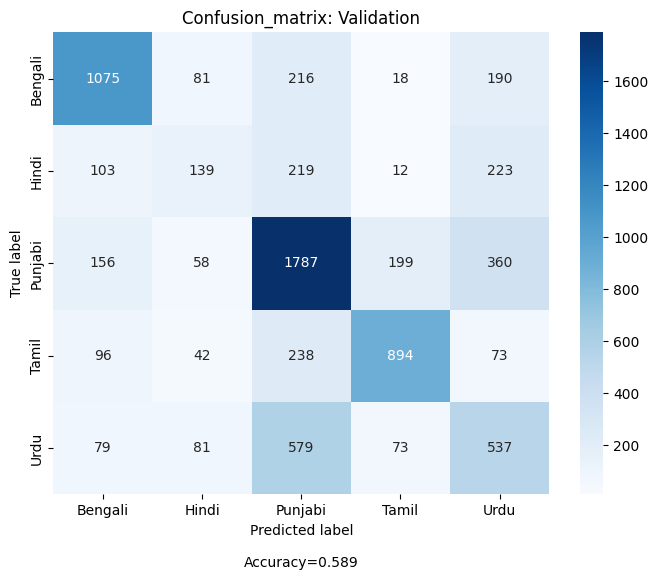

:::::Total vlidation loss 6.0955835474896425, Training accuracy 0.9999804138552388, Validation accuracy 0.5887353878852285 after 26 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 27, Batch: 0, Loss: 0.0011606616899371147, Accuracy:100.0%
Epoch: 27, Batch: 50, Loss: 0.00741054629907012, Accuracy:100.0%
Epoch: 27, Batch: 100, Loss: 0.012498370371758938, Accuracy:100.0%
Epoch: 27, Batch: 150, Loss: 0.0005574139067903161, Accuracy:100.0%
Epoch: 27, Batch: 200, Loss: 0.003145762952044606, Accuracy:100.0%
Epoch: 27, Batch: 250, Loss: 0.0003016538394149393, Accuracy:100.0%
Epoch: 27, Batch: 300, Loss: 0.0006032694363966584, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 6.259341239929199, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 27, Batch: 50, Loss: 10.18189811706543, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 27, Batch: 100, Loss: 19.941051483154297, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 27, Batch: 150, Loss: 2.8417391

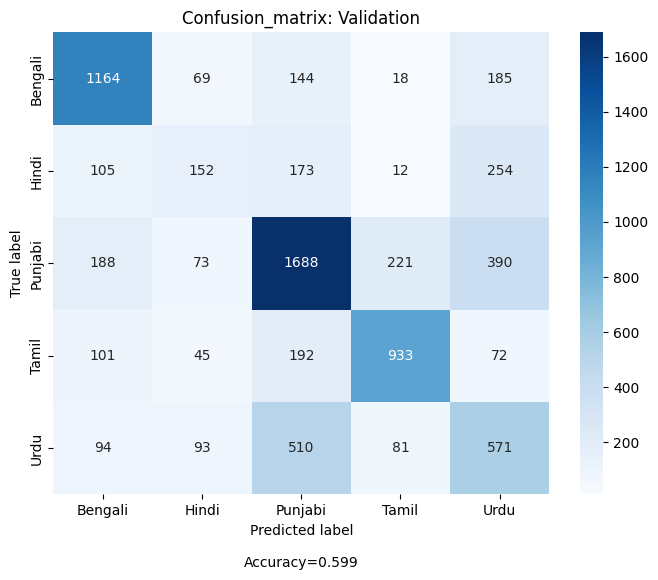

:::::Total vlidation loss 5.864365469231347, Training accuracy 0.9999902069276194, Validation accuracy 0.5988310308182784 after 27 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 28, Batch: 0, Loss: 0.0003993141290266067, Accuracy:100.0%
Epoch: 28, Batch: 50, Loss: 0.003842076053842902, Accuracy:100.0%
Epoch: 28, Batch: 100, Loss: 0.0003118779568467289, Accuracy:100.0%
Epoch: 28, Batch: 150, Loss: 0.004394337069243193, Accuracy:100.0%
Epoch: 28, Batch: 200, Loss: 0.009612428955733776, Accuracy:100.0%
Epoch: 28, Batch: 250, Loss: 0.0027605302166193724, Accuracy:100.0%
Epoch: 28, Batch: 300, Loss: 0.0011572014773264527, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 5.98252534866333, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 28, Batch: 50, Loss: 10.750164031982422, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 28, Batch: 100, Loss: 17.61177635192871, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 28, Batch: 150, Loss: 1.9376933

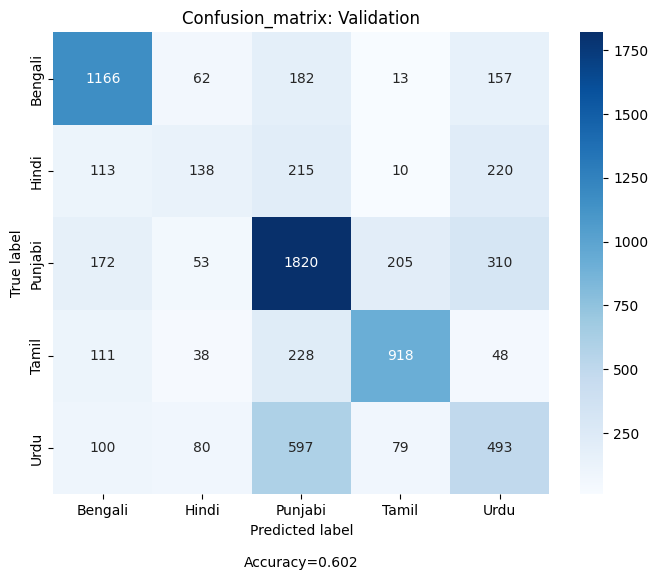

:::::Total vlidation loss 5.904166557166871, Training accuracy 1.0, Validation accuracy 0.6024176408076515 after 28 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 29, Batch: 0, Loss: 0.00194544589612633, Accuracy:100.0%
Epoch: 29, Batch: 50, Loss: 0.0002160367148462683, Accuracy:100.0%
Epoch: 29, Batch: 100, Loss: 0.0009590137051418424, Accuracy:100.0%
Epoch: 29, Batch: 150, Loss: 0.0013094048481434584, Accuracy:100.0%
Epoch: 29, Batch: 200, Loss: 0.00022936279128771275, Accuracy:100.0%
Epoch: 29, Batch: 250, Loss: 0.0009851453360170126, Accuracy:100.0%
Epoch: 29, Batch: 300, Loss: 0.002390052191913128, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 6.872378349304199, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 29, Batch: 50, Loss: 9.687098503112793, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 29, Batch: 100, Loss: 18.08187484741211, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 150, Loss: 1.75145423412323, Accura

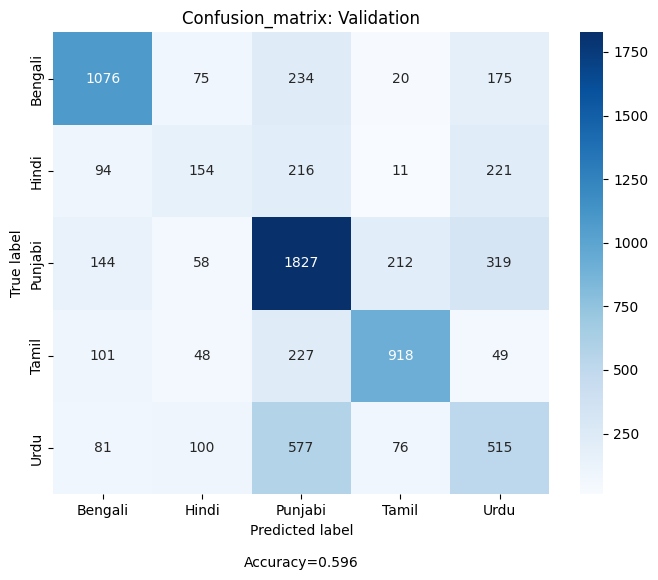

:::::Total vlidation loss 5.938600023331682, Training accuracy 0.9999902069276194, Validation accuracy 0.5964399574920297 after 29 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 30, Batch: 0, Loss: 0.02293011173605919, Accuracy:99.66666666666667%
Epoch: 30, Batch: 50, Loss: 0.004173583816736937, Accuracy:100.0%
Epoch: 30, Batch: 100, Loss: 0.0028108120895922184, Accuracy:100.0%
Epoch: 30, Batch: 150, Loss: 0.000479065376566723, Accuracy:100.0%
Epoch: 30, Batch: 200, Loss: 0.0016250796616077423, Accuracy:100.0%
Epoch: 30, Batch: 250, Loss: 0.0035909004509449005, Accuracy:100.0%
Epoch: 30, Batch: 300, Loss: 0.0016585212433710694, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 6.361994743347168, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 30, Batch: 50, Loss: 11.197521209716797, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 30, Batch: 100, Loss: 19.758819580078125, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 30, Batch: 150, Lo

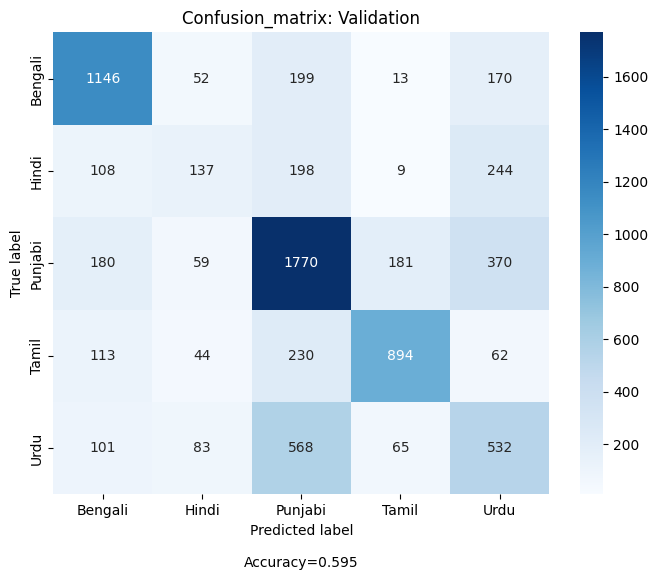

:::::Total vlidation loss 6.007492409324533, Training accuracy 0.9999804138552388, Validation accuracy 0.5949787460148778 after 30 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 31, Batch: 0, Loss: 0.0010330262593925, Accuracy:100.0%
Epoch: 31, Batch: 50, Loss: 0.00042788233258761466, Accuracy:100.0%
Epoch: 31, Batch: 100, Loss: 0.008434251882135868, Accuracy:100.0%
Epoch: 31, Batch: 150, Loss: 0.001295345718972385, Accuracy:100.0%
Epoch: 31, Batch: 200, Loss: 0.00020932884945068508, Accuracy:100.0%
Epoch: 31, Batch: 250, Loss: 0.0029342519119381905, Accuracy:100.0%
Epoch: 31, Batch: 300, Loss: 0.00013622302503790706, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 31, Batch: 0, Loss: 7.1047043800354, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 31, Batch: 50, Loss: 8.510665893554688, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 31, Batch: 100, Loss: 16.963123321533203, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 31, Batch: 150, Loss: 1.659437417

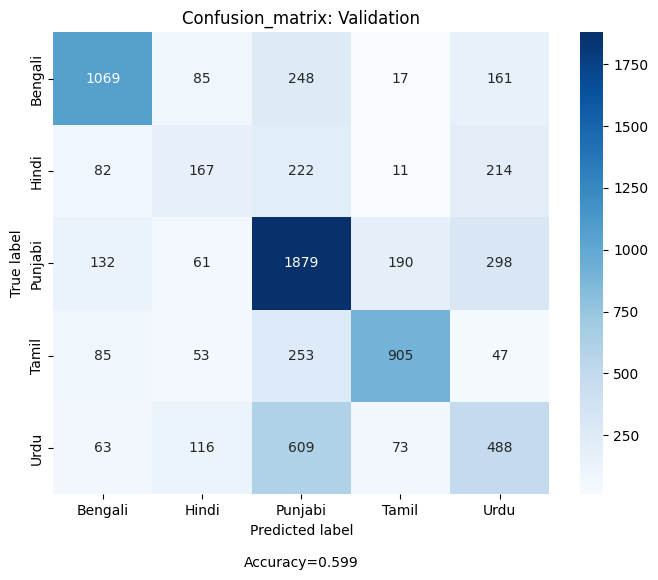

:::::Total vlidation loss 5.925661807616625, Training accuracy 1.0, Validation accuracy 0.5988310308182784 after 31 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 32, Batch: 0, Loss: 0.00036915953387506306, Accuracy:100.0%
Epoch: 32, Batch: 50, Loss: 0.00665634498000145, Accuracy:100.0%
Epoch: 32, Batch: 100, Loss: 0.001449831761419773, Accuracy:100.0%
Epoch: 32, Batch: 150, Loss: 0.0025212380569428205, Accuracy:100.0%
Epoch: 32, Batch: 200, Loss: 0.0010360798332840204, Accuracy:100.0%
Epoch: 32, Batch: 250, Loss: 0.00015387244638986886, Accuracy:100.0%
Epoch: 32, Batch: 300, Loss: 0.0002467101439833641, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 0, Loss: 6.154577255249023, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 32, Batch: 50, Loss: 8.646390914916992, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 32, Batch: 100, Loss: 16.801454544067383, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 32, Batch: 150, Loss: 1.96132493019104, Ac

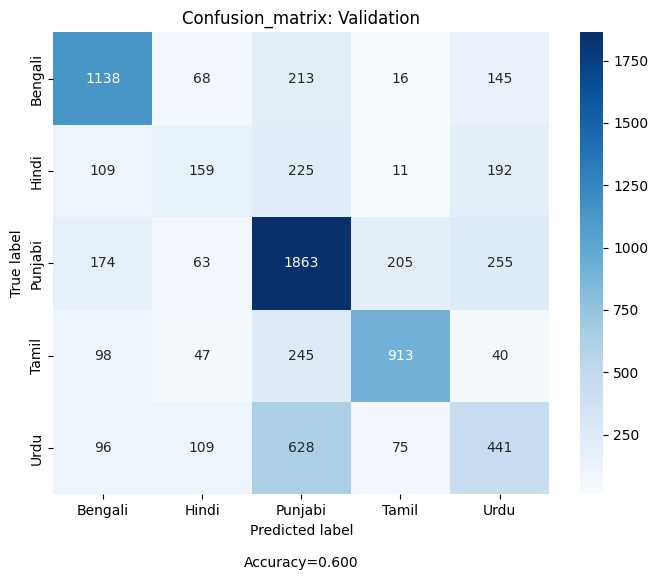

:::::Total vlidation loss 5.874520284852679, Training accuracy 1.0, Validation accuracy 0.5996280552603613 after 32 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 33, Batch: 0, Loss: 0.0007072160369716585, Accuracy:100.0%
Epoch: 33, Batch: 50, Loss: 0.0006412781658582389, Accuracy:100.0%
Epoch: 33, Batch: 100, Loss: 0.00023530665202997625, Accuracy:100.0%
Epoch: 33, Batch: 150, Loss: 0.0002565477916505188, Accuracy:100.0%
Epoch: 33, Batch: 200, Loss: 0.0009892560774460435, Accuracy:100.0%
Epoch: 33, Batch: 250, Loss: 0.0009421738213859499, Accuracy:100.0%
Epoch: 33, Batch: 300, Loss: 0.00046919664600864053, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 0, Loss: 6.260707855224609, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 33, Batch: 50, Loss: 8.196794509887695, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 33, Batch: 100, Loss: 16.632837295532227, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 33, Batch: 150, Loss: 1.8220939636230469,

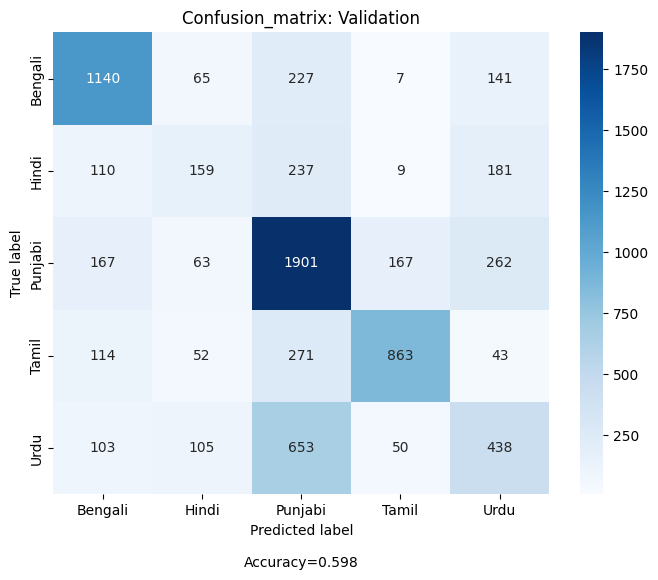

:::::Total vlidation loss 6.020112184988731, Training accuracy 1.0, Validation accuracy 0.5979011689691818 after 33 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 34, Batch: 0, Loss: 0.007740268483757973, Accuracy:100.0%
Epoch: 34, Batch: 50, Loss: 0.0004160575626883656, Accuracy:100.0%
Epoch: 34, Batch: 100, Loss: 0.003593424567952752, Accuracy:100.0%
Epoch: 34, Batch: 150, Loss: 0.0020246687345206738, Accuracy:100.0%
Epoch: 34, Batch: 200, Loss: 0.016656316816806793, Accuracy:100.0%
Epoch: 34, Batch: 250, Loss: 0.0026257557328790426, Accuracy:100.0%
Epoch: 34, Batch: 300, Loss: 0.00031696687801741064, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 0, Loss: 6.1979522705078125, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 34, Batch: 50, Loss: 8.919411659240723, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 34, Batch: 100, Loss: 18.11548614501953, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 150, Loss: 2.615903854370117, Accura

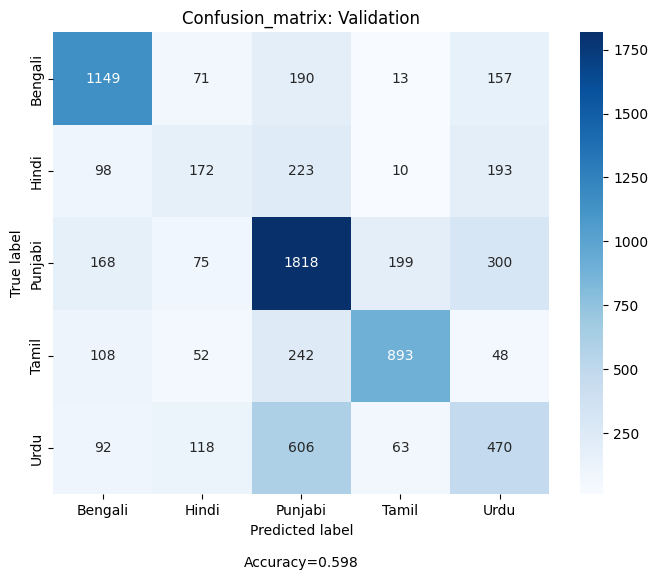

:::::Total vlidation loss 5.969863218109665, Training accuracy 0.9999902069276194, Validation accuracy 0.5980340063761955 after 34 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 35, Batch: 0, Loss: 0.00024280862999148667, Accuracy:100.0%
Epoch: 35, Batch: 50, Loss: 0.0005281856283545494, Accuracy:100.0%
Epoch: 35, Batch: 100, Loss: 0.004562560003250837, Accuracy:100.0%
Epoch: 35, Batch: 150, Loss: 0.00014179528807289898, Accuracy:100.0%
Epoch: 35, Batch: 200, Loss: 0.003780356142669916, Accuracy:100.0%
Epoch: 35, Batch: 250, Loss: 0.0006929180817678571, Accuracy:100.0%
Epoch: 35, Batch: 300, Loss: 0.0030153284315019846, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 0, Loss: 6.697343826293945, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 35, Batch: 50, Loss: 9.989274024963379, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 35, Batch: 100, Loss: 17.075408935546875, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 35, Batch: 150, Loss: 1.90

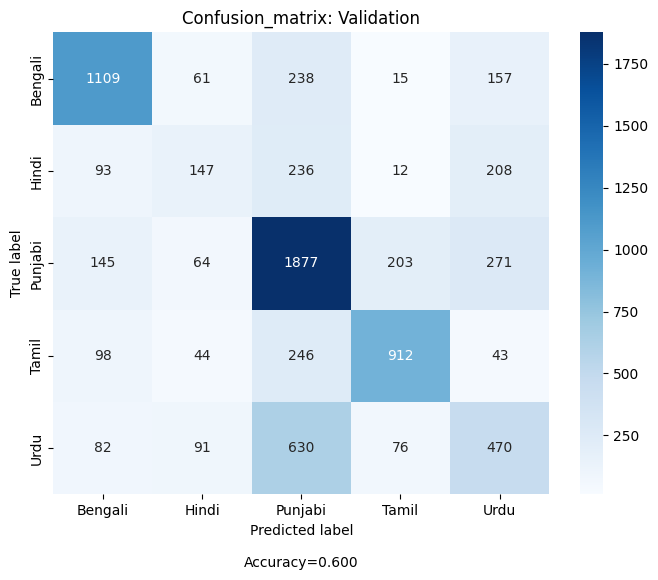

:::::Total vlidation loss 5.98023840142777, Training accuracy 1.0, Validation accuracy 0.5997608926673751 after 35 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 36, Batch: 0, Loss: 0.00016842514742165804, Accuracy:100.0%
Epoch: 36, Batch: 50, Loss: 0.0008512274362146854, Accuracy:100.0%
Epoch: 36, Batch: 100, Loss: 0.0006796239176765084, Accuracy:100.0%
Epoch: 36, Batch: 150, Loss: 0.00033450350747443736, Accuracy:100.0%
Epoch: 36, Batch: 200, Loss: 0.0003476099227555096, Accuracy:100.0%
Epoch: 36, Batch: 250, Loss: 0.0002327999973203987, Accuracy:100.0%
Epoch: 36, Batch: 300, Loss: 0.0002864966227207333, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 0, Loss: 6.841818809509277, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 36, Batch: 50, Loss: 10.077674865722656, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 36, Batch: 100, Loss: 17.06474494934082, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 150, Loss: 2.248004198074341, Acc

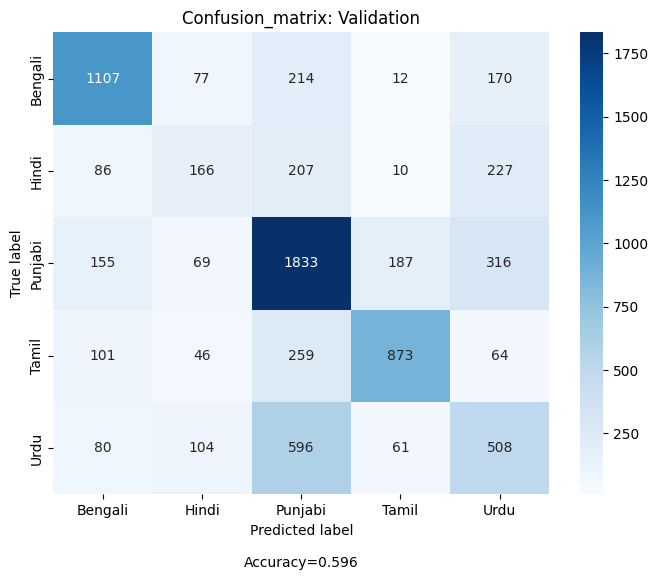

:::::Total vlidation loss 6.014551180211432, Training accuracy 1.0, Validation accuracy 0.5960414452709883 after 36 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 37, Batch: 0, Loss: 0.0004170488682575524, Accuracy:100.0%
Epoch: 37, Batch: 50, Loss: 0.0024142134934663773, Accuracy:100.0%
Epoch: 37, Batch: 100, Loss: 0.0006783335702493787, Accuracy:100.0%
Epoch: 37, Batch: 150, Loss: 0.0004959420184604824, Accuracy:100.0%
Epoch: 37, Batch: 200, Loss: 0.00016935504390858114, Accuracy:100.0%
Epoch: 37, Batch: 250, Loss: 0.0015010024653747678, Accuracy:100.0%
Epoch: 37, Batch: 300, Loss: 0.00027033514925278723, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 0, Loss: 6.2996745109558105, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 37, Batch: 50, Loss: 10.319724082946777, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 37, Batch: 100, Loss: 18.752565383911133, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 150, Loss: 2.216780662536621

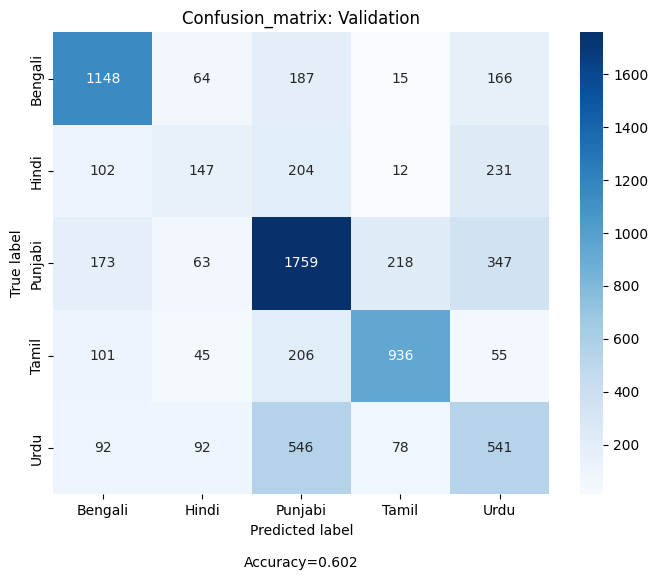

:::::Total vlidation loss 5.953361818944908, Training accuracy 1.0, Validation accuracy 0.6018862911795961 after 37 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 38, Batch: 0, Loss: 0.0001689614582573995, Accuracy:100.0%
Epoch: 38, Batch: 50, Loss: 0.00018694932805374265, Accuracy:100.0%
Epoch: 38, Batch: 100, Loss: 0.00017434573965147138, Accuracy:100.0%
Epoch: 38, Batch: 150, Loss: 0.0006341558764688671, Accuracy:100.0%
Epoch: 38, Batch: 200, Loss: 0.005826454143971205, Accuracy:100.0%
Epoch: 38, Batch: 250, Loss: 0.0032157753594219685, Accuracy:100.0%
Epoch: 38, Batch: 300, Loss: 0.0004293458769097924, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 0, Loss: 5.766526222229004, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 38, Batch: 50, Loss: 10.280778884887695, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 100, Loss: 18.416908264160156, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 150, Loss: 2.4405386447906494, A

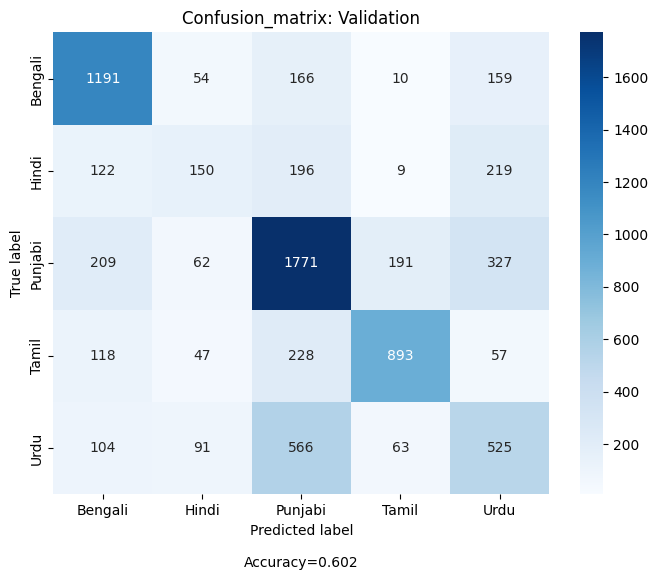

:::::Total vlidation loss 5.989777561536688, Training accuracy 1.0, Validation accuracy 0.6017534537725824 after 38 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 39, Batch: 0, Loss: 0.00028089372790418565, Accuracy:100.0%
Epoch: 39, Batch: 50, Loss: 0.0005188257782720029, Accuracy:100.0%
Epoch: 39, Batch: 100, Loss: 0.0011088114697486162, Accuracy:100.0%
Epoch: 39, Batch: 150, Loss: 0.011823602952063084, Accuracy:100.0%
Epoch: 39, Batch: 200, Loss: 0.0036966740153729916, Accuracy:100.0%
Epoch: 39, Batch: 250, Loss: 0.0047190068289637566, Accuracy:100.0%
Epoch: 39, Batch: 300, Loss: 0.0012054896214976907, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 39, Batch: 0, Loss: 6.502743244171143, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 39, Batch: 50, Loss: 9.06027889251709, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 39, Batch: 100, Loss: 18.100828170776367, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 39, Batch: 150, Loss: 2.3263142108917236, Accu

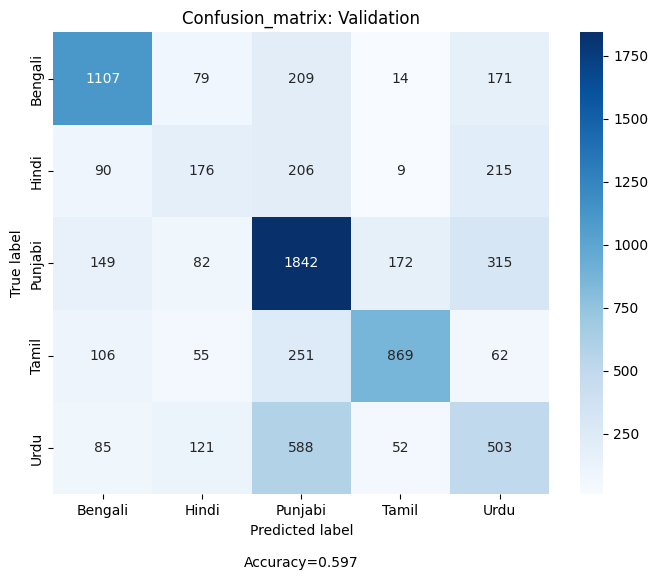

:::::Total vlidation loss 6.030892194368091, Training accuracy 1.0, Validation accuracy 0.5973698193411264 after 39 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 40, Batch: 0, Loss: 0.0008005995769053698, Accuracy:100.0%
Epoch: 40, Batch: 50, Loss: 8.132746734190732e-05, Accuracy:100.0%
Epoch: 40, Batch: 100, Loss: 0.0015158255118876696, Accuracy:100.0%
Epoch: 40, Batch: 150, Loss: 0.0003932974359486252, Accuracy:100.0%
Epoch: 40, Batch: 200, Loss: 0.0005242167972028255, Accuracy:100.0%
Epoch: 40, Batch: 250, Loss: 0.0004286656330805272, Accuracy:100.0%
Epoch: 40, Batch: 300, Loss: 0.0009144051582552493, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 40, Batch: 0, Loss: 7.383979797363281, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 40, Batch: 50, Loss: 9.779074668884277, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 40, Batch: 100, Loss: 16.89765167236328, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 40, Batch: 150, Loss: 2.0143377780914307, Ac

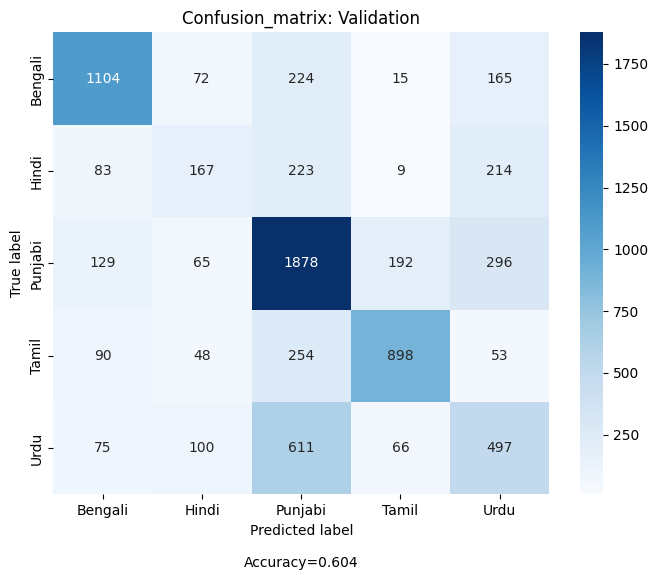

:::::Total vlidation loss 5.919073743982325, Training accuracy 1.0, Validation accuracy 0.6036131774707758 after 40 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 41, Batch: 0, Loss: 0.0002753301814664155, Accuracy:100.0%
Epoch: 41, Batch: 50, Loss: 0.00046694453340023756, Accuracy:100.0%
Epoch: 41, Batch: 100, Loss: 0.00012919626897200942, Accuracy:100.0%
Epoch: 41, Batch: 150, Loss: 0.0010461914353072643, Accuracy:100.0%
Epoch: 41, Batch: 200, Loss: 0.0002937005483545363, Accuracy:100.0%
Epoch: 41, Batch: 250, Loss: 0.00027163344202563167, Accuracy:100.0%
Epoch: 41, Batch: 300, Loss: 0.004201239440590143, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 41, Batch: 0, Loss: 6.742032527923584, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 41, Batch: 50, Loss: 10.682943344116211, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 41, Batch: 100, Loss: 18.25728988647461, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 41, Batch: 150, Loss: 1.8227505683898926,

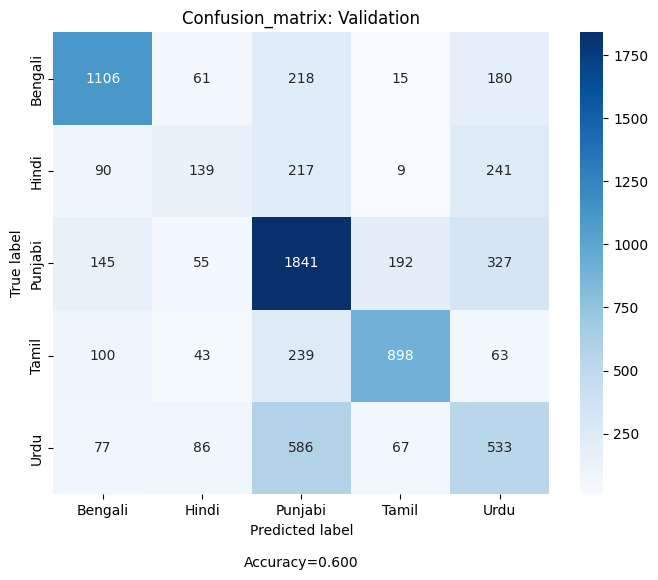

:::::Total vlidation loss 5.977314656678082, Training accuracy 1.0, Validation accuracy 0.6000265674814028 after 41 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 42, Batch: 0, Loss: 0.000630453578196466, Accuracy:100.0%
Epoch: 42, Batch: 50, Loss: 0.0013699975097551942, Accuracy:100.0%
Epoch: 42, Batch: 100, Loss: 0.0001513648749096319, Accuracy:100.0%
Epoch: 42, Batch: 150, Loss: 0.00019595347112044692, Accuracy:100.0%
Epoch: 42, Batch: 200, Loss: 0.00023986912856344134, Accuracy:100.0%
Epoch: 42, Batch: 250, Loss: 0.00025693944189697504, Accuracy:100.0%
Epoch: 42, Batch: 300, Loss: 0.00030201871413737535, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 42, Batch: 0, Loss: 6.635627746582031, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 42, Batch: 50, Loss: 9.644464492797852, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 42, Batch: 100, Loss: 18.257844924926758, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 42, Batch: 150, Loss: 1.9746201038360596,

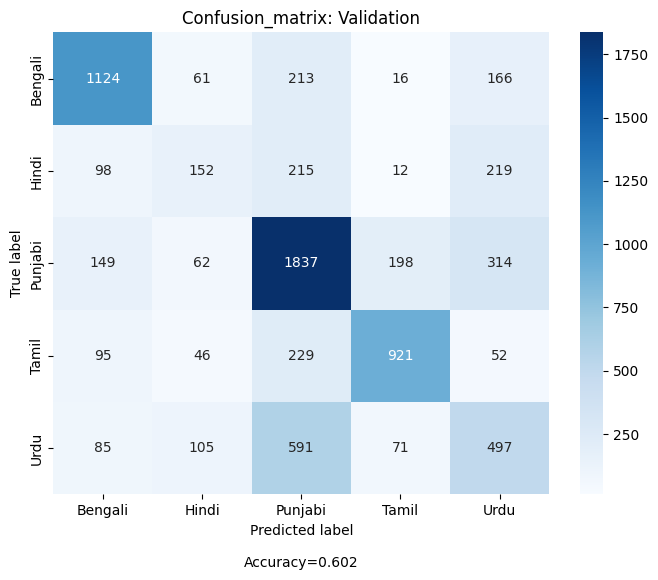

:::::Total vlidation loss 5.946982444667758, Training accuracy 1.0, Validation accuracy 0.6018862911795961 after 42 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 43, Batch: 0, Loss: 0.00042328500421717763, Accuracy:100.0%
Epoch: 43, Batch: 50, Loss: 0.0009561470942571759, Accuracy:100.0%
Epoch: 43, Batch: 100, Loss: 5.530598355107941e-05, Accuracy:100.0%
Epoch: 43, Batch: 150, Loss: 0.00014116571401245892, Accuracy:100.0%
Epoch: 43, Batch: 200, Loss: 0.00017583984299562871, Accuracy:100.0%
Epoch: 43, Batch: 250, Loss: 0.0009502163738943636, Accuracy:100.0%
Epoch: 43, Batch: 300, Loss: 0.00018629171245265752, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 43, Batch: 0, Loss: 5.670477390289307, Accuracy:59.375%


KeyboardInterrupt: 

In [13]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path,exist_ok=True)
#Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix
def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        #features=torch.transpose(features,0,2,1)
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss=model.get_loss(pred_logits,labels)
        posterior=model.get_posterior()
        #print(posterior.shape)
        #loss = loss_fun(pred_logits,labels)

        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=torch.transpose(features,0,2,1)
            features, labels = features.to(device).float(),labels.to(device).long()
            pred_logits = model(features)
            #print(features.shape)
            #print(labels.shape)
            loss=model.get_loss(pred_logits,labels)
            posterior=model.get_posterior()
            #loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path,'cross_corpora_bhagya_LDC_Augmented_ecapa_cms_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100))+"_"+str("{:.4f}".format(mean_loss2)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc=train(trainloader,epoch)
        val_loss=validation(testloader1,epoch,mean_acc)
        scheduler.step(val_loss)
        #testing(testloader2,epoch,mean_acc)
        #testing(testloader3,epoch,mean_acc)